Index(['is_ev_rej', 'run_number', 'ev_id', 'centrality', 'z_vtx_reco',
       'z_vtx_gen', 'n_tracklets'],
      dtype='object')


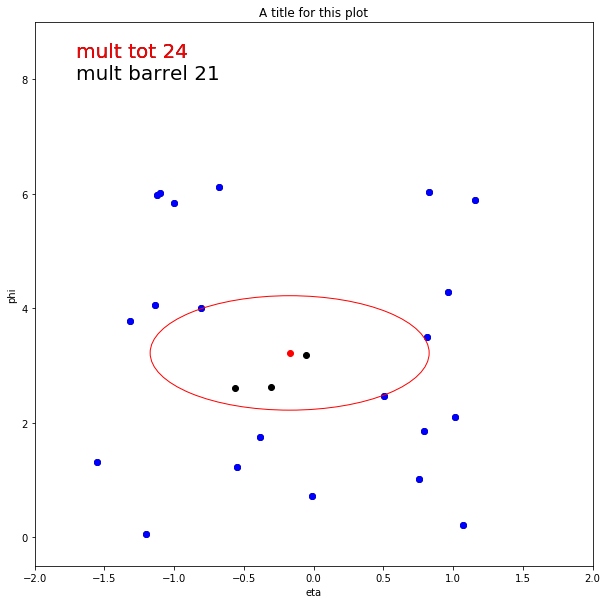

0    3
Name: Dmultbarrel, dtype: int64
0    21
Name: Dmultout, dtype: int64
      d_len  d_len_xy   norm_dl  norm_dl_xy     cos_p  cos_p_xy  imp_par_xy  \
0  0.030921  0.021979  0.581299    0.299049  0.570549     0.985   -0.003793   

        dca  cos_t_star  imp_par_prod  ...  z_vtx_reco  z_vtx_gen  \
0  0.009312    0.952954      0.000016  ...    1.772199   1.771954   

   n_tracklets  isstd  ismcsignal  ismcprompt  ismcfd  ismcbkg  Dmultbarrel  \
0           14      0           1           1       0        0            3   

   Dmultout  
0        21  

[1 rows x 41 columns]


In [3]:
import sys 
import math
import array 
import multiprocessing as mp 
import pickle 
import os 
import random as rd 
import uproot 
import pandas as pd 
import numpy as np 
from root_numpy import fill_hist # pylint: disable=import-error, no-name-in-module 
from ROOT import TFile, TH1F, TH2F # pylint: disable=import-error, no-name-in-module 
import numba
import matplotlib.pyplot as plt


from machine_learning_hep.selectionutils import selectfidacc 
from machine_learning_hep.bitwise import filter_bit_df, tag_bit_df 
from machine_learning_hep.utilities import selectdfquery, selectdfrunlist, merge_method 
from machine_learning_hep.utilities import list_folders, createlist, appendmainfoldertolist 
from machine_learning_hep.utilities import create_folder_struc, seldf_singlevar, openfile 
from machine_learning_hep.models import apply # pylint: disable=import-error 


def scatterplotetaphi(arrayx, arrayy, arrayxsel, arrayysel, output, name, Deta=-1, Dphi=-1, Rcut=-1):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    if Rcut is not -1:
        circle = plt.Circle((Deta, Dphi), Rcut, color='r',fill=False)
        ax.add_artist(circle)
    if Deta is not -1 and Dphi is not -1:
        plt.scatter([Deta],[Dphi], color='r')
    plt.scatter(arrayx, arrayy, color='k')
    plt.scatter(arrayxsel, arrayysel, color='b')
    plt.title('A title for this plot') 

    plt.xlabel("eta")
    plt.ylabel("phi")
    plt.xlim(-2,  2)
    plt.ylim(-0.5, 9)
    ax.text(-1.7, 8, "mult barrel %d" % len(arrayxsel), fontsize=20)
    ax.text(-1.7, 8.4, "mult tot %d" % len(arrayx), fontsize=20)
    ax.text(-1.7, 8.4, "mult tot %d" % len(arrayx), fontsize=20, color="r")
    plt.show()
    plt.savefig(output+"/"+name+".png")
    plt.close()

dfreco = pickle.load(openfile("../machine_learning_hep/mcpklLHC18bdefghijklmnop/child_1/0002/AnalysisResultsReco.pkl.lz4", "rb"))
dftrkl = pickle.load(openfile("../machine_learning_hep/mcpklLHC18bdefghijklmnop/child_1/0002/AnalysisResultsTrkl.pkl.lz4", "rb"))
dfevt = pickle.load(openfile("../machine_learning_hep/mcpklLHC18bdefghijklmnop/child_1/0002/AnalysisResultsEvt.pkl.lz4", "rb"))

dfrecogrouped = dfreco.groupby(["ev_id","run_number"])
dftrklgrouped = dftrkl.groupby(["ev_id","run_number"])

dfreco_mult = pd.DataFrame()

counterev = 0
Rcut = 1.0
for keys, df in dfrecogrouped:
    if counterev > 0:
        break
    trkl_evt = dftrklgrouped.get_group((keys[0],keys[1]))
    Detalist = df["eta_cand"].values
    Dphilist = df["phi_cand"].values

    trkletalist = trkl_evt["TrackletEta"].values
    trklphilist = trkl_evt["TrackletPhi"].values
    Dmultbarrellist = []
    Dmultoutlist = []

    for i, _ in enumerate(Detalist):
        Deta = Detalist[i]
        Dphi = Dphilist[i]
        
        arrayRtrkl = [math.sqrt((Deta-trkleta)*(Deta-trkleta) + (Dphi-trklphi)*(Dphi-trklphi)) \
                      for trkleta, trklphi in zip(trkletalist, trklphilist)]        
        trkl_evt["Rvalue"] = pd.Series(arrayRtrkl, index = trkl_evt.index)
        trkl_evt_bar = trkl_evt[trkl_evt["Rvalue"]<Rcut]
        trkl_evt_out = trkl_evt[trkl_evt["Rvalue"]>Rcut]
        
        scatterplotetaphi(trkl_evt["TrackletEta"], trkl_evt["TrackletPhi"],
                    trkl_evt_out["TrackletEta"], trkl_evt_out["TrackletPhi"], 
                    "plot", "%d_tracklets_event_barrel" % counterev, Deta, Dphi, Rcut)

        Dmultbarrel = len([R for R in arrayRtrkl if R<Rcut])
        Dmultout = len([R for R in arrayRtrkl if R>Rcut])
        Dmultbarrellist.append(Dmultbarrel)
        Dmultoutlist.append(Dmultout)

    df["Dmultbarrel"]= pd.Series(Dmultbarrellist, index=df.index)
    df["Dmultout"]= pd.Series(Dmultoutlist, index=df.index)
    dfreco_mult = pd.concat([dfreco_mult, df], axis = 0)
    counterev = counterev + 1

print(dfreco_mult["Dmultbarrel"])
print(dfreco_mult["Dmultout"])
print(dfreco_mult)